In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score, confusion_matrix, classification_report


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# device configuration
print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.') 
    device = torch.device('cpu')

Using PyTorch version: 2.4.0+cu124
Using GPU, device name: NVIDIA GeForce RTX 4060 Laptop GPU


In [3]:
# define a function to set all seeds to 0
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(0)

In [4]:
# Define a transform to normalize the data to [0,1]
transform = transforms.Compose([transforms.ToTensor()])

# Load the training and test datasets using torchvision
train_dataset = datasets.MNIST(root='../mnist_dataset', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='../mnist_dataset', train=False, download=True, transform=transform)

In [5]:
# Flatten the images for sklearn MLP
X_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

# Summarize loaded dataset
print('Train: X=%s, y=%s' % (X_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


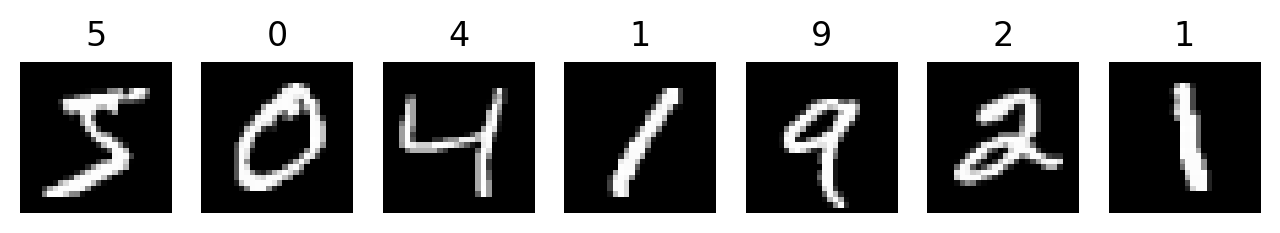

In [6]:
# Plot first few images
fig, axs = plt.subplots(1, 7, figsize=(8, 10))
for i in range(7):
    axs[i].imshow(X_train[i], cmap='gray')
    axs[i].set_title(y_train[i])
    axs[i].axis('off')


In [7]:
# Hyper-parameters
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 60
batch_size = 128
learning_rate = 0.0005


In [8]:
# Data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
# # Create and train the MLP model using PyTorch
# class MLP(nn.Module):
#     def __init__(self, input_size, num_classes, device=device):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, 30, device = device)      # First hidden layer (30 neurons)
#         self.fc2 = nn.Linear(30, 20, device = device)              # Second hidden layer (20 neurons)
#         self.fc3 = nn.Linear(20, num_classes, device = device)     # Output layer (10 neurons)
    
#     def forward(self, x, input_size, device = device):
#         x = x.view(-1, input_size)  # Flatten the image
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)  # No activation here; we'll apply softmax in the loss function
#         return x

In [10]:
class MLP(nn.Module):
    """
    Multi-Layer Perceptron (MLP) for image classification.

    Attributes:
        fc1 (nn.Linear): First fully connected layer.
        relu (nn.ReLU): ReLU activation function.
        fc2 (nn.Linear): Second fully connected layer for output.
    """

    def __init__(self, input_size=28*28, hidden_size=128, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)  # First fully connected layer
        self.relu = nn.ReLU()                           # ReLU activation function
        self.fc2 = nn.Linear(hidden_size, num_classes)  # Second fully connected layer

    def forward(self, x):
        # Flatten the image 
        x = x.reshape(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        out = self.fc2(x)       # No activation here; we'll apply softmax in the loss function
        return out


In [23]:
# Initialize the model
model = MLP(input_size, hidden_size, num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)


MLP(
  (fc1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [24]:
def train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_train_loss += loss.item()
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        train_accuracy = 100 * correct_train / total_train
        train_loss = total_train_loss / len(train_loader)
        
        # Evaluate on test data
        model.eval()
        total_test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        test_accuracy = 100 * correct_test / total_test
        test_loss = total_test_loss / len(test_loader)
        
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Train Accuracy: {train_accuracy:.4f}%, Test Loss: {test_loss:.6f}, Test Accuracy: {test_accuracy:.4f}%')

train_and_evaluate_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

Epoch [10/60], Train Loss: 0.028951, Train Accuracy: 99.2550%, Test Loss: 0.063283, Test Accuracy: 97.9700%
Epoch [20/60], Train Loss: 0.004273, Train Accuracy: 99.9517%, Test Loss: 0.070219, Test Accuracy: 97.9800%
Epoch [30/60], Train Loss: 0.004715, Train Accuracy: 99.8650%, Test Loss: 0.076466, Test Accuracy: 98.0600%
Epoch [40/60], Train Loss: 0.006903, Train Accuracy: 99.7850%, Test Loss: 0.082665, Test Accuracy: 98.1800%
Epoch [50/60], Train Loss: 0.000081, Train Accuracy: 100.0000%, Test Loss: 0.086512, Test Accuracy: 98.2900%
Epoch [60/60], Train Loss: 0.000061, Train Accuracy: 100.0000%, Test Loss: 0.092287, Test Accuracy: 98.2700%


In [25]:
# Save the model checkpoint
torch.save(model.state_dict(), './models/mlp_model.ckpt')

In [11]:
# Load the model checkpoint
model = MLP(input_size, hidden_size, num_classes).to(device)
model.load_state_dict(torch.load('./models/mlp_model.ckpt'))

C:\Users\Shardul Junagade\AppData\Local\Temp\ipykernel_32848\2072702527.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./models/mlp_mo

<All keys matched successfully>

F1 Score: 0.982704
Accuracy: 98.27%


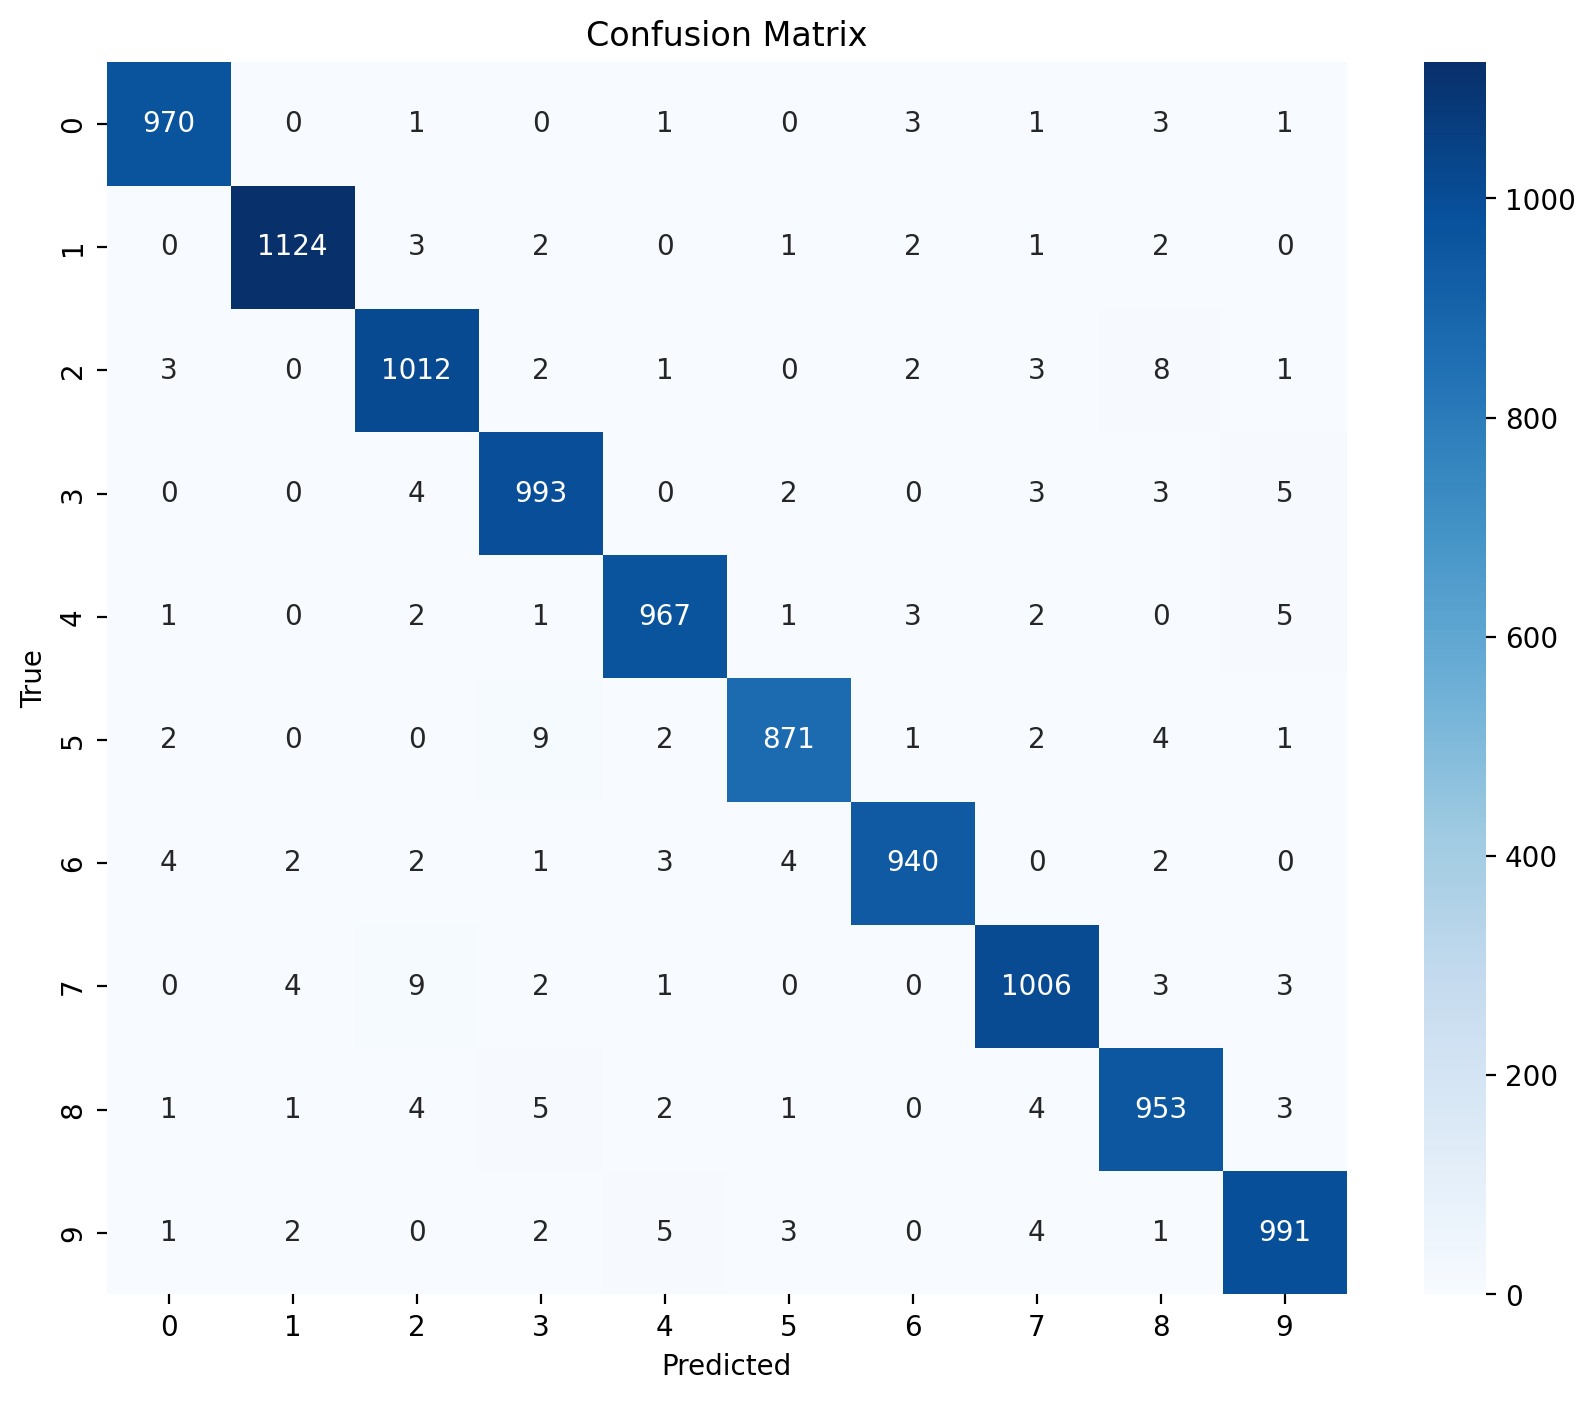

In [15]:
# Evaluate the model and calculate F1 score, confusion matrix, and accuracy
model.eval()
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate F1 score
f1 = f1_score(all_labels, all_predictions, average='weighted')
print(f'F1 Score: {f1:.6f}')

# Calculate accuracy
accuracy = np.mean(np.array(all_labels) == np.array(all_predictions))
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:

print("Classification Report: ")
print(classification_report(all_labels, all_predictions))

Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



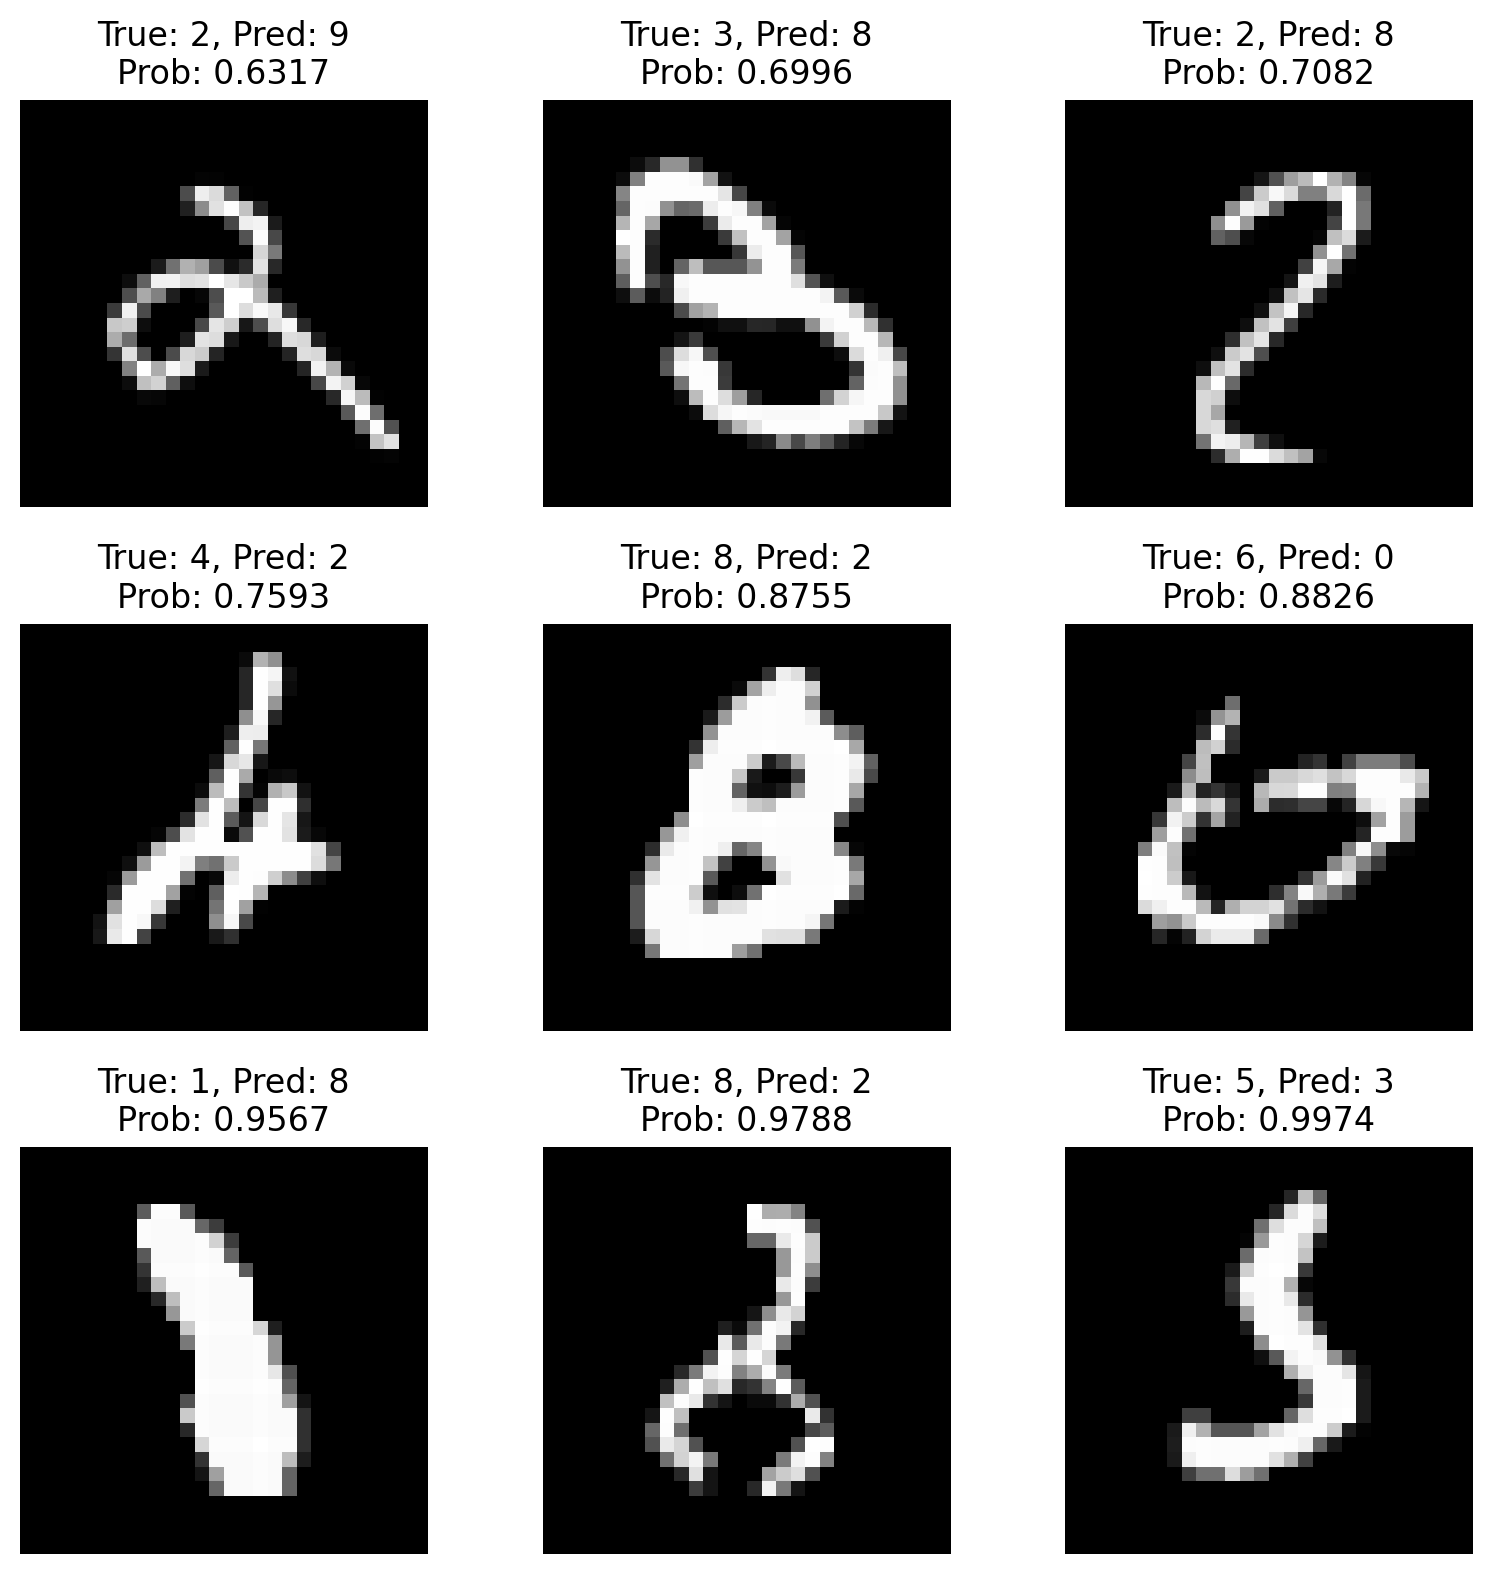

In [20]:
# Display the first k wrongly classified images with highest probability
k = 10
model.eval()
wrong_images = []
wrong_labels = []
wrong_predictions = []
wrong_prob = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        wrong_indices = (predicted != labels).nonzero(as_tuple=True)[0]
        wrong_prob_batch, _ = torch.max(F.softmax(outputs, dim=1), dim=1)
        wrong_prob_batch = wrong_prob_batch[wrong_indices]
        wrong_images_batch = images[wrong_indices]
        wrong_labels_batch = labels[wrong_indices]
        wrong_predictions_batch = predicted[wrong_indices]
        
        wrong_images.extend(wrong_images_batch.cpu())
        wrong_labels.extend(wrong_labels_batch.cpu())
        wrong_predictions.extend(wrong_predictions_batch.cpu())
        wrong_prob.extend(wrong_prob_batch.cpu())
        
        if len(wrong_images) >= k:
            break

# Sort by probability and take the top k
sorted_indices = np.argsort(wrong_prob)[-k:]
wrong_images = [wrong_images[i] for i in sorted_indices]
wrong_labels = [wrong_labels[i] for i in sorted_indices]
wrong_predictions = [wrong_predictions[i] for i in sorted_indices]
wrong_prob = [wrong_prob[i] for i in sorted_indices]

fig, axs = plt.subplots(3, 3, figsize=(8, 8))
for i in range(3):
    for j in range(3):
        idx = i * 3 + j
        axs[i, j].imshow(wrong_images[idx].cpu().numpy().squeeze(), cmap='gray')
        axs[i, j].set_title(f'True: {wrong_labels[idx]}, Pred: {wrong_predictions[idx]}\nProb: {wrong_prob[idx]:.4f}')
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()
